In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Sampler
import numpy as np
import cv2 as cv
import torchlayers as tl
import os
from torchvision.utils import save_image

In [2]:
trans = transforms.Compose([
    transforms.Resize((120, 120)), 
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
trans_gray = transforms.Compose([transforms.Resize((120, 120)), transforms.ToTensor(), transforms.Grayscale(3)])


# datas = torchvision.datasets.ImageFolder(root = './data/cifar100', transform = trans)
# train_size = int(len(datas) * 0.8)
# val_size = len(datas) - train_size
# train_sets, val_sets = torch.utils.data.random_split(datas, [train_size, val_size])

# edge_datas = torchvision.datasets.ImageFolder(root = './data/cifar100_edge', transform = trans_gray)
# edge_train_size = int(len(edge_datas) * 0.8)
# edge_val_size = len(edge_datas) - edge_train_size
# edge_train_sets, edge_val_sets = torch.utils.data.random_split(edge_datas, [edge_train_size, edge_val_size])
train_sets = torchvision.datasets.ImageFolder(root = './data/cifar100_train', transform = trans)
val_sets = torchvision.datasets.ImageFolder(root = './data/cifar100_val', transform = trans)
test_sets = torchvision.datasets.ImageFolder(root = './data/cifar100_test', transform = trans)

edge_train_sets = torchvision.datasets.ImageFolder(root = './data/cifar100_train_edge', transform = trans_gray)
edge_val_sets = torchvision.datasets.ImageFolder(root = './data/cifar100_val_edge', transform = trans_gray)
edge_test_sets = torchvision.datasets.ImageFolder(root = './data/cifar100_test_edge', transform = trans_gray)
labels = test_sets.classes


# edge_train_sets = torchvision.datasets.ImageFolder(root = './data/kcar_edge/lights', transform = trans_gray)
# edge_img_sets = torchvision.datasets.ImageFolder(root = './data/tiny-imagenet-200/edge2', transform = trans_gray)
# train_sets = torchvision.datasets.ImageFolder(root = './data/kcar/lights', transform = trans)
# img_sets = torchvision.datasets.ImageFolder(root = './data/tiny-imagenet-200/train', transform = trans)
# labels = datas.classes

print("edge_train_sets  :", len(edge_train_sets))
print("train_sets       :", len(train_sets))
print("edge_val_sets  :", len(edge_val_sets))
print("val_sets       :", len(val_sets))

print("edge_test_sets  :", len(edge_test_sets))
print("test_sets       :", len(test_sets))
print(len(labels))
# print(labels)
# print(val_sets)
# print(edge_val_sets)


edge_train_sets  : 40000
train_sets       : 40000
edge_val_sets  : 10000
val_sets       : 10000
edge_test_sets  : 10000
test_sets       : 10000
100


In [3]:
# DataLoader 정의 - data 길이 달라지면 random_t_list 수정하기!
import random
train_size = int(len(train_sets))
val_size = len(val_sets)

random_train_list = list(range(1, train_size))
random.shuffle(random_train_list)
random_val_list = list(range(1, val_size))
random.shuffle(random_val_list)

# random_train_list = np.loadtxt("random_train.txt")
# random_val_list = np.loadtxt("random_val.txt")

train_loader = DataLoader(train_sets, batch_size = 32, num_workers = 2, sampler = random_train_list)
edge_train_loader = DataLoader(edge_train_sets, batch_size = 32, num_workers = 2, sampler = random_train_list)
val_loader = DataLoader(val_sets, batch_size = 32, sampler = random_val_list)
edge_val_loader = DataLoader(edge_val_sets, batch_size = 32, sampler = random_val_list)

test_loader = DataLoader(test_sets, batch_size = 32, sampler = random_val_list)
edge_test_loader = DataLoader(edge_test_sets, batch_size = 32, sampler = random_val_list)

print(len(train_loader))

1250


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')
print(torch.cuda.is_available())
torch.cuda.empty_cache()

cuda:0 is available
True


In [5]:
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
 
        _, pred = output.topk(maxk, 1, True, True) #(52, 32)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred)) # (5,32)
 
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [6]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        # self.maxPool = nn.MaxPool1d(3, stride=2)
        self.fc1 = nn.Linear(1000, 100)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(200, 100)
        
    def forward(self, x1, x2):
        x1 = self.modelA(x1)
        # x1 = self.maxPool(x1)
        x1 = self.fc1(x1)

        x2 = self.modelB(x2)
        # x2 = self.maxPool(x2)
        x2 = self.fc2(x2)

        x = torch.cat((x1, x2), dim=1)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):  
        size = x.size()[1:] 
        num_features = 1 
        for s in size: 
            num_features *= s 
        return num_features
# resnet101 = torchvision.models.resnet101(pretrained=True)
# resnet101 = resnet101.cuda()
BLOCK_UNITS = {
    'r50': [3, 4, 6, 3],
    'r101': [3, 4, 23, 3],
    'r152': [3, 8, 36, 3],
}

# from big_transfer_master.bit_pytorch.models import ResNetV2
# resnet101 = ResNetV2(BLOCK_UNITS["r101"], width_factor=1, zero_head=False)
# resnet101.load_from(np.load("BiT-M-R101x1.npz"))

# resnet101_edge = ResNetV2(BLOCK_UNITS["r101"], width_factor=1, zero_head=False)
# resnet101_edge.load_from(np.load("BiT-M-R101x1.npz"))

resnet101 = torchvision.models.resnet101(pretrained=False)
resnet101 = resnet101.cuda()

resnet101_edge = torchvision.models.resnet101(pretrained=False)
resnet101_edge = resnet101_edge.cuda()

model = MyEnsemble(resnet101, resnet101_edge)
model = model.cuda()
print("model created!")

model created!


In [7]:
# model = torch.load('_parallel_resnet101_77.7778_epoch_1.pth')
# model = torch.load('tmp.pt')
trn_loss_list = []
val_loss_list = []

In [8]:
#MyEnsemble 모델 학습 dark version
print(len(train_loader))
print(len(val_loader))
criterion = torch.nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

from sam_offi import SAM
# optimizer = SAMSGD(model.parameters(), lr=1e-1, rho=0.05)
# base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
# optimizer = SAM(model.parameters(), base_optimizer, lr=0.1, momentum=0.9)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,6,8], gamma=0.1)

# hyper-parameters
num_epochs = 20
num_batches = 32

model.train()
max_acc = 30
saved_trn_acc = 0

trn_loss = 0.0
total = 0 
correct = 0
for epoch in range(num_epochs):
    try:
        for i, (data, edge_data) in enumerate(zip(train_loader, edge_train_loader)):
            x, label = data
            x2, label2 = edge_data

            x = x.cuda()
            label = label.cuda()
            x2 = x2.cuda()
            # grad init
            optimizer.zero_grad()
            # forward propagation
            model_output = model(x, x2)
            _, predicted = torch.max(model_output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            # calculate loss
            loss = criterion(model_output, label)
            # back propagation
            loss.backward()
            # weight update
            optimizer.step()

            # trn_loss summary
            trn_loss += loss.item()
            
            # 학습과정 출력
            if (i+1) % 500 == 1:  # every 100 mini-batches
                model.eval()
                with torch.no_grad():  # very very very very important!!!
                    val_loss = 0.0
                    val_total = 0
                    val_correct = 0
                    count = 0
                    for j, (val, edge_val) in enumerate(zip(val_loader, edge_val_loader)):
                        val_x, val_label = val
                        val_x2, val_label2 = edge_val
                        val_x = val_x.cuda()
                        val_x2 = val_x2.cuda()
                        val_label = val_label.cuda()

                        val_output = model(val_x, val_x2)
                        _, predicted = torch.max(val_output.data, 1)
                        val_total += val_label.size(0)
                        val_correct += (predicted == val_label).sum().item()
                        v_loss = criterion(val_output, val_label)
                        val_loss += v_loss
                        count += 1
                        if count < 2 and (100 * val_correct / val_total) < max_acc:
                            break
                    # print("----------------valing data: " +
                        # str(j * len(val_loader)))
                    # acc1, acc5 = accuracy(model_output, label, topk=(1, 5))
                    # print("train acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
                    # print('Accuracy of the network on the train images: %f %%' %
                        # (100 * correct / total))
                    # acc1, acc5 = accuracy(val_output, val_label, topk=(1, 5))
                    # print("val acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
                    # print('Accuracy of the network on the val images: %f %%' %
                        # (100 * val_correct / val_total))
                    print('{}: train: {:.4f}%, val: {:.4f}%'.format(j * len(val_loader), (100 * correct / total), (100 * val_correct / val_total)))

                    if (100 * val_correct / val_total) > max_acc:
                        max_acc = (100 * val_correct / val_total)
                        saved_trn_acc = (100 * correct / total)
                        MODEL = "false_parallel_resnet101"
                        path = "./models/"
                        torch.save(model, f'{path}_{MODEL}_{(100 * val_correct / val_total):.4f}_epoch_{epoch}.pth')

                print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
                    epoch+1, num_epochs, i+1, len(train_loader), trn_loss / total, val_loss / val_total))
                print("-----------------max accuracy : {:.4f}, train acc : {:.4f}--------------".format(max_acc, saved_trn_acc))
                
                trn_loss_list.append(trn_loss/total)
                val_loss_list.append(val_loss/val_total)
                # val_loss_list.append(val_loss/len(val_loader))
                trn_loss = 0.0
                total = 0 
                correct = 0
                model.train()

            del model_output
    except (OSError) as e:
        print(e)
    # scheduler.step()
#plotting the loss chart 


1250
313
0: train: 0.0000%, val: 0.0000%
epoch: 1/20 | step: 1/1250 | trn loss: 0.1438 | val loss: 0.1437
-----------------max accuracy : 30.0000, train acc : 0.0000--------------


KeyboardInterrupt: 

In [ ]:
torch.save(model, 'tmp.pt')

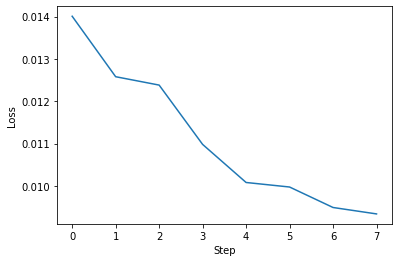

In [ ]:

# plt.plot([x in x.cpu() from trn_loss_list])
plt.plot(trn_loss_list[6:])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

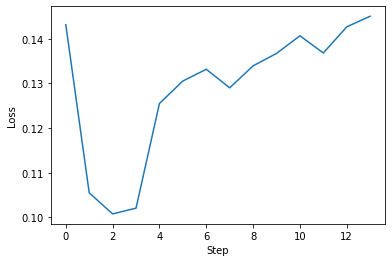

In [ ]:

# plt.plot([x in x.cpu() from trn_loss_list])
val = []
for l in val_loss_list:
    val.append(l.cpu())
plt.plot(val)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

In [ ]:
torch.save(model, 'tmp.pt')

In [9]:
model = torch.load('_false_parallel_resnet101_37.6438_epoch_3.pth')

In [10]:
# MyEnsemble 테스트
model.eval()
correct = 0
total = 0
class_correct = np.zeros(100)
class_total = np.zeros(100)
count = 0
print(len(test_loader))
print(len(labels))
with torch.no_grad():
    for index, ((images, targets), (edge_images, edge_target)) in enumerate(zip(test_loader, edge_test_loader)):
        images = images.cuda()
        edge_images = edge_images.cuda()
        targets = targets.cuda()

        outputs = model(images, edge_images)
        _, predicted = torch.max(outputs.data, 1)
        acc1, acc5 = accuracy(outputs, targets, topk=(1, 5))
        # print("acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        c = (predicted == targets).squeeze()
        count += 1
        for i in range(32):
            target = targets[i]
            class_correct[target] += c[i].item()
            class_total[target] += 1
        if count > len(test_loader)/10:
            break
            
# for i in range(100):
    # print('Accuract of %5s : %2d %%' %(
        # labels[i], 100 * class_correct[i] / class_total[i]))
        
print('Accuracy of the network on the test images: %f %%' % (
      100 * correct / total))

313
100
Accuracy of the network on the test images: 39.160156 %


In [ ]:
#MyEnsemble 모델 학습
import torch.optim as optim
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(sqnet.parameters(), lr=0.01, betas=(0.9, 0.99), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4,6,8], gamma=0.1)

model.train()
print(len(train_loader))
for epoch in range(10):
    for index, ((data, target), (edge_data, edge_target)) in enumerate(zip(train_loader, edge_train_loader)):
        data, target = data.cuda(), target.cuda()
        edge_data, edge_target = edge_data.cuda(), target.cuda()

        output = model(data, edge_data)
        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if index % 50 == 0:
            acc1, acc5 = accuracy(outputs, targets, topk=(1, 5))
            print("acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
            print("loss of {} epoch, {} index : {}".format(epoch, index, loss.item()))
    
    scheduler.step()
    print("-----")



780


RuntimeError: mat1 dim 1 must match mat2 dim 0

In [ ]:
def imshow(img):
    # img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labs = dataiter.next()
edge_dataiter = iter(edge_test_loader)
edge_images, labs = edge_dataiter.next()

# 이미지 출력하기
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%10s' % labels[labs[j]] for j in range(4)))

outputs = model(images, edge_images)
_, predicted = torch.max(outputs, 1)
print('Predicted : ', ' '.join('%10s' % labels[predicted[j]] for j in range(4)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for ((images, labels), (edge_images, edge_target)) in zip(test_loader, edge_test_loader):
        images = images.cuda()
        edge_images = edge_images.cuda()
        labels = labels.cuda()
        outputs = model(images, edge_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the test images: %f %%' % (
      100 * correct / total))

Accuracy of the network on the test images: 23.553636 %


In [ ]:
class_correct = list(0. for i in range(51))
class_total = list(0. for i in range(51))
classes = labels
count = 0
with torch.no_grad():
    for ((images, labels), (edge_images, edge_target)) in zip(test_loader, edge_test_loader):
    # for data in test_loader:
        images = images.cuda()
        edge_images = edge_images.cuda()
        labels = labels.cuda()
        outputs = model(images, edge_images)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        print(labels)
        c = (predicted == labels).squeeze()
        count += 1
        for i in range(32):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        if count > 200:
            break
            
for i in range(51):
    print('Accuract of %5s : %2d %%' %(
        classes[i], 100 * class_correct[i] / class_total[i]))

tensor([25, 25,  3, 25,  3, 25, 25, 25, 25, 25, 25,  3,  2, 25,  3, 25,  2,  3,
        25, 25,  2, 25, 25, 33, 25,  2, 25,  2,  2,  3, 25, 25],
       device='cuda:0')
tensor([48, 18, 15,  2, 24, 23, 36, 38, 47, 44, 35, 46, 49,  7,  7, 24,  2, 21,
         4,  7,  7,  2, 18, 13, 42,  7, 18,  7, 44, 49, 15, 40],
       device='cuda:0')
tensor([25,  2,  3, 25, 25,  3, 25, 25,  2, 25, 25, 25,  2,  3, 25,  2,  2,  2,
         2,  2, 25, 25, 25, 25, 25, 25, 25, 25,  3, 25, 25,  3],
       device='cuda:0')
tensor([12, 25, 33,  8, 11,  1, 11, 48, 45, 36, 33, 50,  3, 20, 26, 17,  3, 24,
        33, 10, 33,  3,  1, 23, 48, 18, 41, 15, 44, 11, 23, 50],
       device='cuda:0')
tensor([ 2, 25, 25,  3, 25,  3,  3, 25, 25, 25, 25,  2, 25, 25,  3, 25, 25,  3,
        25, 25, 25, 25, 25,  3, 25, 25,  3, 25, 25,  2,  3, 25],
       device='cuda:0')
tensor([23, 24,  2, 41,  5, 18, 10, 37, 41, 31,  7,  4, 15,  0, 25, 10, 41, 10,
        33, 34,  4,  8, 33, 49, 22,  8, 10, 28, 44, 18,  6, 43],
       dev

IndexError: index 32 is out of bounds for dimension 0 with size 32

In [ ]:
model.eval()  # test
test_loss = 0
correct = 0
with torch.no_grad():
  for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    output = one_way_model(data)
    test_loss += one_way_criterion(output, target).item() # sum up batch loss
    pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    print("pred : "+str(pred)+"view as : "+str(target.view_as(pred)))
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))